In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import pandas as pd
import seaborn as sns
import re

from module.one_dim.layers import *
from module.one_dim.generators import *
plt.rcParams["font.size"] = 18

In [22]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

In [60]:
path = 'trained_model/20220608_1'
model = tf.keras.models.load_model(path)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 image_resizing_2 (ImageResi  (None, 14, 14)           0         
 zing)                                                           
                                                                 
 image_to1d_2 (ImageTo1D)    (None, 196)               0         
                                                                 
 intensity_to_electric_field  (None, 196)              0         
 _2 (IntensityToElectricFiel                                     
 d)                                                              
                                                                 
 modulation_10 (Modulation)  (None, 196)               198       
                                                           

In [25]:
model.layers[5].get_config()

{'name': 'angular_spectrum_10',
 'trainable': True,
 'dtype': 'float32',
 'wavelength': 1.55e-06,
 'wavelength_effect': 1.55e-06,
 'k_effect': 4053667.940115862,
 'z': 4e-05,
 'd': 5e-07,
 'n': 1.0}

In [ ]:
history = pd.read_csv(path + '/history.csv')

fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.plot(range(1, history.index.stop + 1), history['loss'], color='black', label='Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('epoch')
#ax2.plot(range(1, history.index.stop + 1), history['accuracy'], color='red', label='Accuracy')
#ax2.set_ylabel('Accuracy')
# label1と2には、凡例用に各labelのリスト情報が入る
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
# 凡例をまとめて出力する
ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)
ax1.grid(False)
ax2.grid(False)
fig.savefig("out/loss.png")

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
fillters = categorical_output(np.arange(10), 14*14, padding=0.2)
y_cate = y_pred @ fillters.T
y_hat = np.argmax(y_cate, axis=1)
np.count_nonzero(y_hat==y_test)/10000

In [ ]:
# 混同行列
pred_label = tf.argmax(model.predict(x_test), axis=-1).numpy()
cm = tf.math.confusion_matrix(y_test, pred_label)
label_tot = np.sum(cm, axis=1).reshape(-1, 1)
norm_cm = cm/label_tot

In [ ]:
plt.figure(figsize=(7, 7))
sns.heatmap(norm_cm, square=True, cbar=False, annot=True, fmt=".2f", cmap='BuPu')
plt.rcParams["font.size"] = 13
plt.xlabel("Predicted label", fontsize=13)
plt.ylabel("True label", fontsize=13)
plt.title("Normalized confusion matrix")

In [ ]:
image_num = 3
hidden_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
hidden_pred = hidden_model.predict(x_test[0:image_num,:,:])
pred = model.predict(x_test[0:image_num,:,:])
x = np.arange(len(hidden_pred[1,:])) * 0.5e-6

outputs = categorical_output(np.arange(10), 14*14, padding=0.2)
area = np.sum(outputs, axis=0) * 3

plt.figure(figsize=(7,4))
for i in range(image_num):
    plt.plot(x-np.mean(x), pred[i,:]+ 1*i, label="input="+str(y_test[i]))

plt.fill_between(x - np.mean(x), 0, area, alpha=0.5, ec=None, color="thistle")
#plt.plot(outputs[2,:] * np.max(hidden_pred[1,:]), x-np.mean(x), label="true pattern")
ax = plt.gca()
ax.set_facecolor("white")
ax.spines['top'].set_color('#555555')
ax.spines['bottom'].set_color('#555555')
ax.spines['left'].set_color('#555555')
ax.spines['right'].set_color('#555555')
ax.tick_params(axis = 'x', colors ='#555555')
ax.tick_params(axis = 'y', colors = '#555555')
plt.grid(False)
plt.xticks([],[])
plt.yticks([],[])
#plt.legend(bbox_to_anchor=(1.05, 1), fontsize=20)

plt.savefig("out/img2.png", transparent=False)


plt.legend(facecolor="inherit", bbox_to_anchor=(1.05, 1))
plt.tight_layout()

In [ ]:
plt.figure(figsize=(3,9))
x = np.arange(len(hidden_pred[1,:])) * 0.5e-6
plt.plot(hidden_pred[1,:],x - np.mean(x), label="predict pattern")

outputs = categorical_output(np.arange(10), 14*14, padding=0.2)

area = np.sum(outputs, axis=0) * np.max(hidden_pred[1,:])
plt.fill_betweenx(x - np.mean(x), area*0.0, area, alpha=0.5, ec=None, color="thistle")
#plt.plot(outputs[2,:] * np.max(hidden_pred[1,:]), x-np.mean(x), label="true pattern")

plt.grid(False)
plt.xticks([],[])
plt.yticks([],[])
#plt.legend(bbox_to_anchor=(1.05, 1), fontsize=20)

plt.savefig("out/img2.png", transparent=True)

In [ ]:
y_onehot = tf.one_hot(y_test, 10)

y_pred = model.predict(x_test)
loss = tf.losses.categorical_crossentropy(y_onehot, y_pred)

In [11]:
y_pred = model.predict(x_test)
y_test_pattern = categorical_output(y_test, width=14*14, padding=0.2)
loss = tf.losses.mean_squared_error(y_test_pattern, y_pred)

2022-06-17 15:16:43.888524: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-17 15:16:44.000713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [ ]:
loss = tf.losses.categorical_crossentropy(tf.one_hot(y_test,10), y_pred)

7977


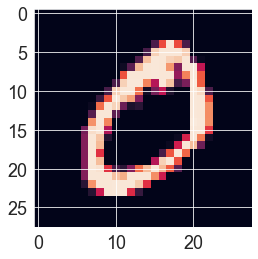

In [20]:
argmin = np.argmin(loss.numpy())
print(argmin)
plt.imshow(x_train[1, :, :])

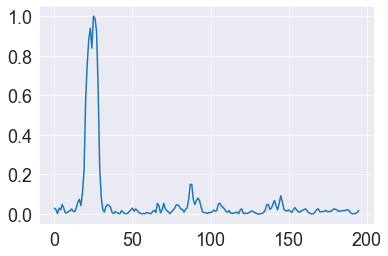

In [19]:
pred = model.predict(np.array([x_train[1,:,:]]))
y = np.arange(len(pred[0,:])) * 0.5e-6
plt.plot(pred[0,:])

In [ ]:
model.layers[5].get_config()

In [ ]:
pred = model.predict(np.array([x_test[4049,:,:]]))
y = np.arange(len(pred[0,:])) * 0.5e-6
plt.plot(pred[0,:])

In [ ]:
model.layers[5].get_config()

2022-06-16 10:42:24.401176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


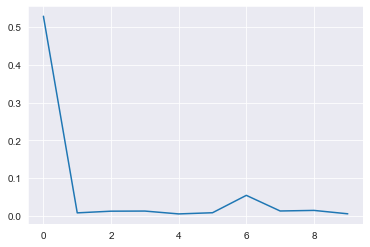

In [68]:
pred = model.predict(np.array([x_test[4049,:,:]]))
y = np.arange(len(pred[0,:])) * 0.5e-6
plt.plot(pred[0,:])

In [115]:
model.layers[5].get_config()

{'name': 'angular_spectrum_10',
 'trainable': True,
 'dtype': 'float32',
 'wavelength': 1.55e-06,
 'wavelength_effect': 1.55e-06,
 'k_effect': 4053667.940115862,
 'z': 4e-05,
 'd': 5e-07,
 'n': 1.0}

In [13]:
pattern = r'modulation'
mo_layers = []
save = False
each_save = True
for layer in model.layers:
    result = re.match(pattern, layer.name)
    if result:
        mo_layers.append(layer)

In [31]:
phase = []
for layer in mo_layers:
    phase.append(layer.get_weights()[0] % (2*np.pi))
phase = np.array(phase).T

hidden_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[2].output)
hidden_pred = hidden_model.predict(np.array([x_test[7977,:,:]]))

data = np.hstack([hidden_pred[0,:].reshape([-1, 1]), phase])
data = pd.DataFrame(data, columns=["Intensity", "layer1", "layer2", "layer3", "layer4", "layer5"])
data.to_csv("out/phase.csv")

2022-06-08 17:15:21.539463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


## モデルストラクチャ

/var/folders/dq/z_0g0_d101gg2c_06s9yqp8h0000gn/T/ipykernel_39320/345180692.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im = ax.pcolormesh(C % (2*np.pi), vmin=0., vmax=2*np.pi, cmap='rocket')
/var/folders/dq/z_0g0_d101gg2c_06s9yqp8h0000gn/T/ipykernel_39320/345180692.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0,2*np.pi])
/var/folders/dq/z_0g0_d101gg2c_06s9yqp8h0000gn/T/ipykernel_39320/345180692.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


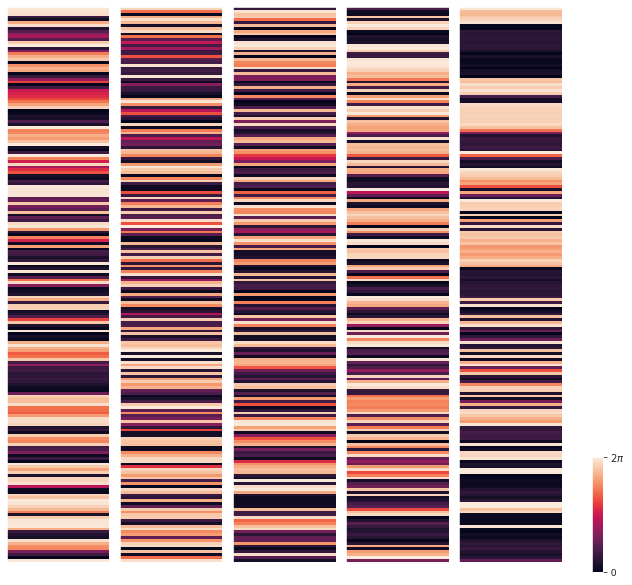

In [66]:
patten = 'modulation'
weights = []
for layer in model.layers:
    if re.match(patten, layer.name):
        weights.append(layer.get_weights()[0])
weights = np.array(weights).T

fig, axes = plt.subplots(1, weights.shape[1], figsize=(8, 8))
for i, ax in enumerate(axes):
    C = np.reshape(weights[:, i], [-1, 1])
    im = ax.pcolormesh(C % (2*np.pi), vmin=0., vmax=2*np.pi, cmap='rocket')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    if i==len(axes)-1:
        axpos = axes[-1].get_position()
        cbar_ax = fig.add_axes([axpos.x1+axpos.width, 0, 0.02, 0.2])
        cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0,2*np.pi])
        cbar.ax.set_yticklabels(['0', r'$2\pi$'])  # vertically oriented colorbar

fig.tight_layout()

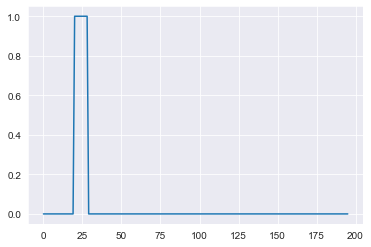

In [96]:
outputs = categorical_output(np.arange(10), 14*14, padding=0.2)
plt.plot(outputs[0,:])

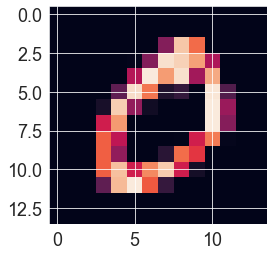

In [32]:
data = np.loadtxt("out/phase.csv", skiprows=1, delimiter=",")
image = np.reshape(data[:,0], [14, 14])
plt.imshow(image)

In [61]:
weights = model.layers[4].get_weights()

In [70]:
def create_model(z):
    inputs = tf.keras.Input((28, 28))
    x = ImageResizing([14, 14])(inputs)
    x = ImageTo1D()(x)
    x = IntensityToElectricField()(x)
    x = Modulation()(x)
    x = AngularSpectrum(wavelength=1.55e-6, z=z, d=0.5e-6, n=1, method="expand")(x)
    x = ElectricFieldToIntensity()(x)
    return tf.keras.Model(inputs, x)

out = []
z = np.linspace(0, 40.e-6, 200)
for z_ in z:
    model = create_model(z_)
    w = model.layers[4].get_weights()
    w[0] = weights[0]
    model.layers[4].set_weights(w)
    pred = model.predict(np.array([x_train[1,:,:]]))
    out.append(pred[0,:])

2022-06-17 16:59:40.350305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-17 16:59:40.416446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-17 16:59:40.480057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-17 16:59:40.546591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-17 16:59:40.625299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-17 16:59:40.693311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-17 16:59:40.756572: I tensorflow/core/grappler/optimizers/cust

/var/folders/dq/z_0g0_d101gg2c_06s9yqp8h0000gn/T/ipykernel_49859/2639235045.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(YY, ZZ, out)


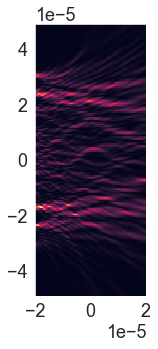

In [84]:
y = np.arange(196) * 0.5e-6
ZZ, YY = np.meshgrid(y-np.mean(y), z-np.mean(z))
plt.figure(figsize=(5,5))
out = np.array(out)
plt.pcolormesh(YY, ZZ, out)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(False)
plt.savefig("out/layer1-propagation.png", dpi=300)